## Import Libraries and Dataset

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

## NLP ##
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

## Visualization ##
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Import the dataset
df = pd.read_csv('https://raw.githubusercontent.com/Kurniaman/ITFest-Unpad/main/Dataset%20Babak%20Penyisihan.csv')
df

,label,tweet
0,fear,Lebih menyeramkan kalo punya grup WA keluarga ...
1,joy,"Hepibesdey canteeeekk [USERNAME] panjang umur,..."
2,joy,Jumat lalu nonton inih! Selain tertarik settin...
3,joy,Nyante dulu.. Sruput kopi biar tambah bijak...
4,love,Happy annyversarry yg pertama kalinya .. Trsra...
...,...,...
5148,NaN,Aku termasuk orang yang tidak habis pikir deng...
5149,NaN,"Melawan sibuk Selasamu, jangan patah semangat ..."
5150,NaN,Momen di mana kamu merasa begitu mendalam terh...
5151,NaN,Tapi tentunya secara ini Bekasi ada hal-hal yg...


## Data Processing

In [ ]:
def clean_text(text):
    # Memastikan bahwa nilai adalah string
    if isinstance(text, str):
        # Menghapus karakter khusus, tanda baca, dan angka
        text = re.sub(r'[-()\#/@;:<>{}=~|.?,!]', '', text)

        # Menghapus kata-kata yang tidak relevan (misalnya, kata-kata berhenti)
        stopwords = set(['dan', 'atau', 'saya', 'kamu', 'dia', 'itu', 'yang', 'yg', 'di', 'ada', 'ini', 'bisa', 'tak', 'aku','ada', 'tapi'])
        words = text.split()

        # Daftar kata atau frasa yang ingin dihapus
        words_to_remove = set(['[USERNAME]', '[URL]'])

        # hapus kata tidak relevan
        words = [word for word in words if word.lower() not in stopwords and word not in words_to_remove]

        # Mengganti karakter html dengan tanda petik
        text = re.sub('<.*?>', ' ', text)

        # Mempertimbangkan huruf dan angka
        text = re.sub('[^a-zA-Z]', ' ', text)

        # Mengganti line baru dengan spasi
        text = re.sub("\n"," ", text)

        # Menyeragamkan menjadi huruf kecil
        text = text.lower()

        # Menghapus single character
        text = re.sub(r"\b[a-zA-Z]\b", " ", text)

        # Menggabungkan kata-kata bersih menjadi satu string
        cleaned_text = ' '.join(words)

        return cleaned_text
    else:
        # Jika nilai bukan string, kembalikan nilai asli
        return text

df['tweet'] = df['tweet'].apply(clean_text)

# Tampilkan DataFrame yang telah dibersihkan
df['tweet']

0       Lebih menyeramkan kalo punya grup WA keluarga ...
1       Hepibesdey canteeeekk panjang umur jadi pribad...
2       Jumat lalu nonton inih Selain tertarik setting...
3               Nyante dulu Sruput kopi biar tambah bijak
4       Happy annyversarry pertama kalinya Trsrah org ...
                              ...                        
5148    termasuk orang tidak habis pikir dengan orang ...
5149     Melawan sibuk Selasamu jangan patah semangat yah
5150    Momen mana merasa begitu mendalam terhubung de...
5151    tentunya secara Bekasi halhal sayangnya tidak ...
5152    Happy Mensive My Love makasih udh nemenin sela...
Name: tweet, Length: 5153, dtype: object

## Data Splitting

In [ ]:
# Separate labeled items
train_test_df = df.head(4153)

# Separate unlabeled items
predict_label = df[-1000:].copy()

predict_label.reset_index(drop=True, inplace=True)

In [ ]:
# Check if there's any null values in the dataset
train_test_df.isna().sum()

label    0
tweet    2
dtype: int64

In [ ]:
# Find the location of the null values
np.where(train_test_df.isna())

(array([ 611, 1081]), array([1, 1]))

In [ ]:
# Make a new copy of the dataset and delete the null values to prevent 'SettingWithCopyWarning'
train_test_df_copy = train_test_df.copy()
train_test_df_copy.dropna(subset=['tweet'], inplace=True)  # Drop rows with missing tweet content

In [ ]:
# Replace the old dataset with the new one
train_test_df = train_test_df_copy
train_test_df.isna().sum()

label    0
tweet    0
dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Seperate the two labels into each individual variables
tweets = train_test_df['tweet']
labels = train_test_df['label']

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit the label encoder to your categories and transform the labels
encoded_labels = label_encoder.fit_transform(labels)

labels = encoded_labels

tweets

0       Lebih menyeramkan kalo punya grup WA keluarga ...
1       Hepibesdey canteeeekk panjang umur jadi pribad...
2       Jumat lalu nonton inih Selain tertarik setting...
3               Nyante dulu Sruput kopi biar tambah bijak
4       Happy annyversarry pertama kalinya Trsrah org ...
                              ...                        
4148    sini berobat sama ngantri dokter saja sudah ke...
4149    Selamat pagi generasi Tik Tok kadang kepalanya...
4150    Salah satu sahabat terbaik Teman kakak inspira...
4151    Gila kok ya perempuan pikirannya malah nyinyir...
4152    coba hubungi cakung minta wa balik untuk tanya...
Name: tweet, Length: 4151, dtype: object

In [ ]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(tweets, labels, test_size=0.2, random_state=42)

## EDA

### Sentiment Distribution

In [ ]:
sentiment_counts = df['label'].value_counts().sort_index()

sentiment_labels = ['fear', 'joy', 'love', 'sadness', 'anger']
sentiment_colors = ['red', 'grey', 'green', 'blue', 'yellow']

fig = go.Figure(data=[go.Pie(labels=sentiment_counts.index,
                             values=sentiment_counts.values,
                             textinfo='percent+value+label',
                             marker_colors=sentiment_colors,
                             textposition='auto',
                             hole=.3)])

fig.update_layout(
    title_text='Sentiment Distribution',
    template='plotly_white',
    xaxis=dict(
        title='Sources',
    ),
    yaxis=dict(
        title='Number of Posts in Twitter',
    )
)

fig.update_traces(marker_line_color='black',
                  marker_line_width=1.5,
                  opacity=0.8)

fig.show()

### Word counts for each sentiment

In [ ]:
def get_all_string(sentences):
    sentence = ''
    for words in sentences:
        sentence += words
    sentence = re.sub('[^A-Za-z0-9 ]+', '', sentence)
    sentence = re.sub(r'http\S+', '', sentence)
    sentence = sentence.lower()
    return sentence

def get_word(sentence):
    return nltk.RegexpTokenizer(r'\w+').tokenize(sentence)

def remove_stopword(word_tokens):
    stopword_list = stopwords.words('english')
    filtered_tokens = []

    for word in word_tokens:
        if word not in stopword_list:
            filtered_tokens.append(word)
    return filtered_tokens

def lemmatize_words(filtered_tokens):
    lemm = WordNetLemmatizer()
    cleaned_tokens = [lemm.lemmatize(word) for word in filtered_tokens]
    return cleaned_tokens

def create_freq_df(cleaned_tokens):
    fdist = nltk.FreqDist(cleaned_tokens)
    freq_df = pd.DataFrame.from_dict(fdist, orient='index')
    freq_df.columns = ['Frequency']
    freq_df.index.name = 'Term'
    freq_df = freq_df.sort_values(by=['Frequency'], ascending=False)
    freq_df = freq_df.reset_index()
    return freq_df

In [ ]:
def preprocess(series):
    all_string = get_all_string(series)
    words = get_word(all_string)
    filtered_tokens = remove_stopword(words)
    cleaned_tokens = lemmatize_words(filtered_tokens)
    return cleaned_tokens

def plot_text_distribution(x_df, y_df, color, title, xaxis_text, yaxis_text):

    fig = px.bar(x=x_df,
                y=y_df,
                color=y_df,
                text=y_df,
                color_continuous_scale=color)

    fig.update_layout(
        title_text=title,
        template='plotly_white',
        xaxis=dict(
            title=xaxis_text,
        ),
        yaxis=dict(
            title=yaxis_text,
        )
    )

    fig.update_traces(marker_line_color='black',
                    marker_line_width=1.5,
                    opacity=0.8)

    fig.show()

def create_wordcloud(freq_df, title, color):

    data = freq_df.set_index('Term').to_dict()['Frequency']

    plt.figure(figsize = (20,15))
    wc = WordCloud(width=800,
               height=400,
               max_words=100,
               colormap= color,
               max_font_size=200,
               min_font_size = 1 ,
               random_state=8888,
               background_color='white').generate_from_frequencies(data)

    plt.imshow(wc, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

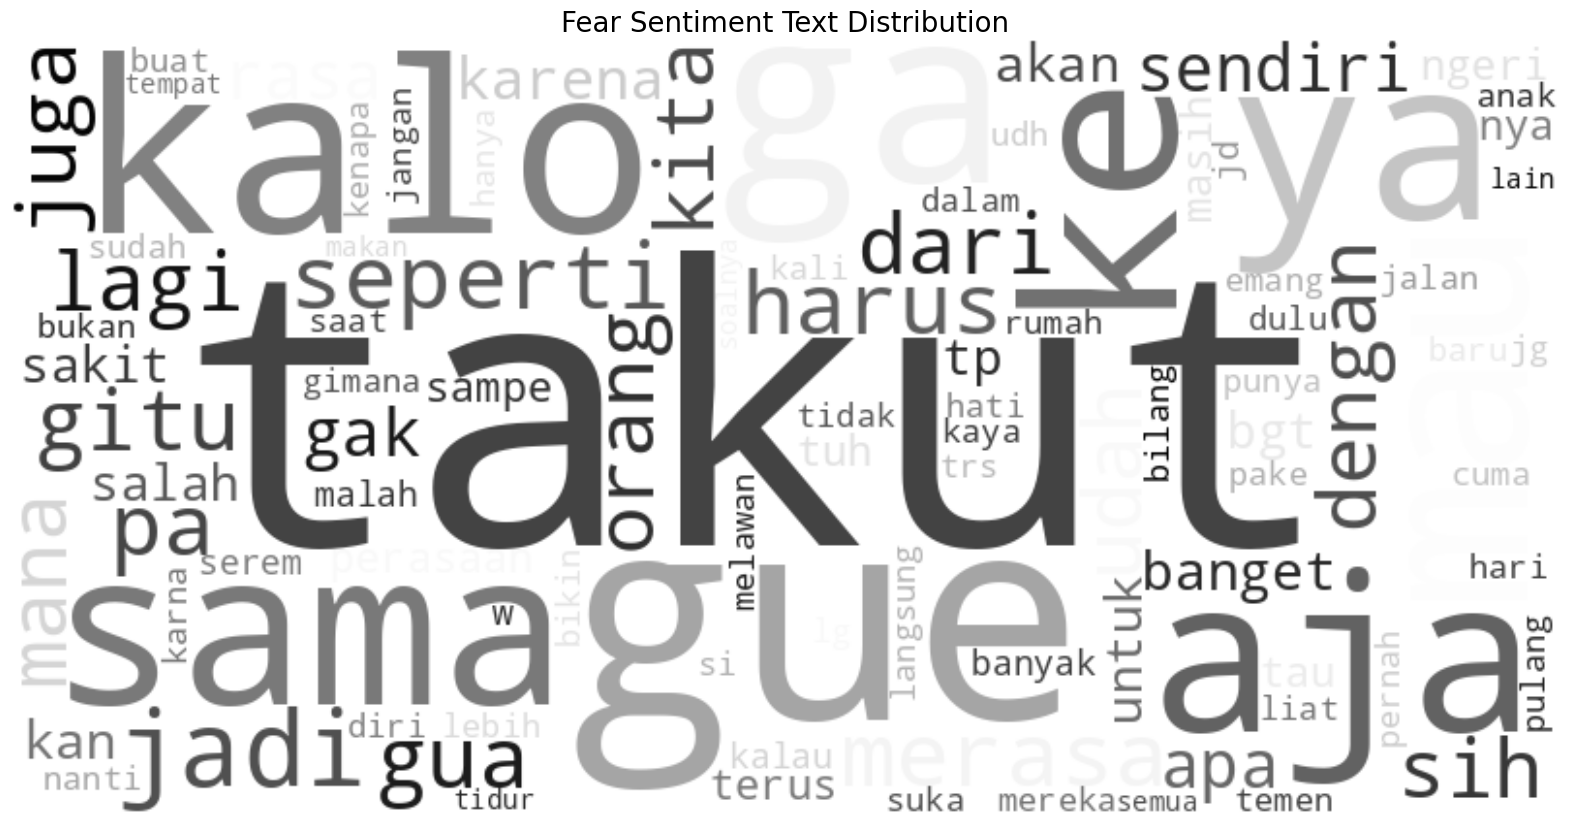

In [ ]:
fear_words = preprocess(train_test_df.loc[train_test_df['label'] == 'fear']['tweet'])
fear_words_df = create_freq_df(fear_words)
top10_positive_words = fear_words_df[:10]

plot_text_distribution(top10_positive_words['Term'], top10_positive_words['Frequency'],
                  'Greys', 'Top 10 Fear Sentiment Text Distribution', 'Text', 'Number of Texts')
create_wordcloud(fear_words_df, 'Fear Sentiment Text Distribution', 'binary_r')

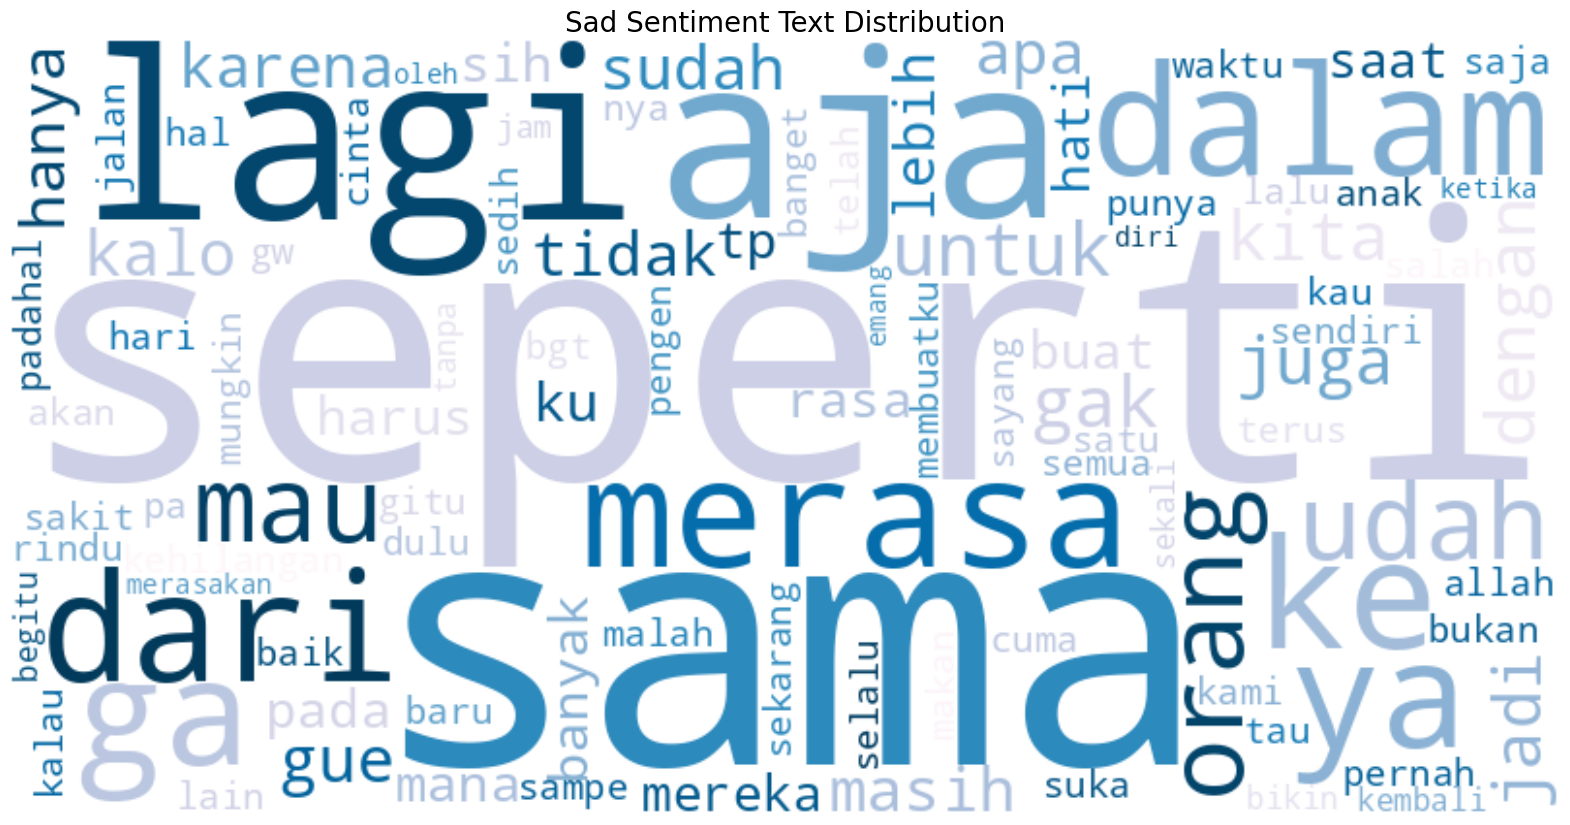

In [ ]:
sad_words = preprocess(train_test_df.loc[train_test_df['label'] == 'sadness']['tweet'])
sad_words_df = create_freq_df(sad_words)
top10_positive_words = sad_words_df[:10]

plot_text_distribution(top10_positive_words['Term'], top10_positive_words['Frequency'],
                  'Blues', 'Top 10 Sad Sentiment Text Distribution', 'Text', 'Number of Texts')
create_wordcloud(sad_words_df, 'Sad Sentiment Text Distribution', 'PuBu')

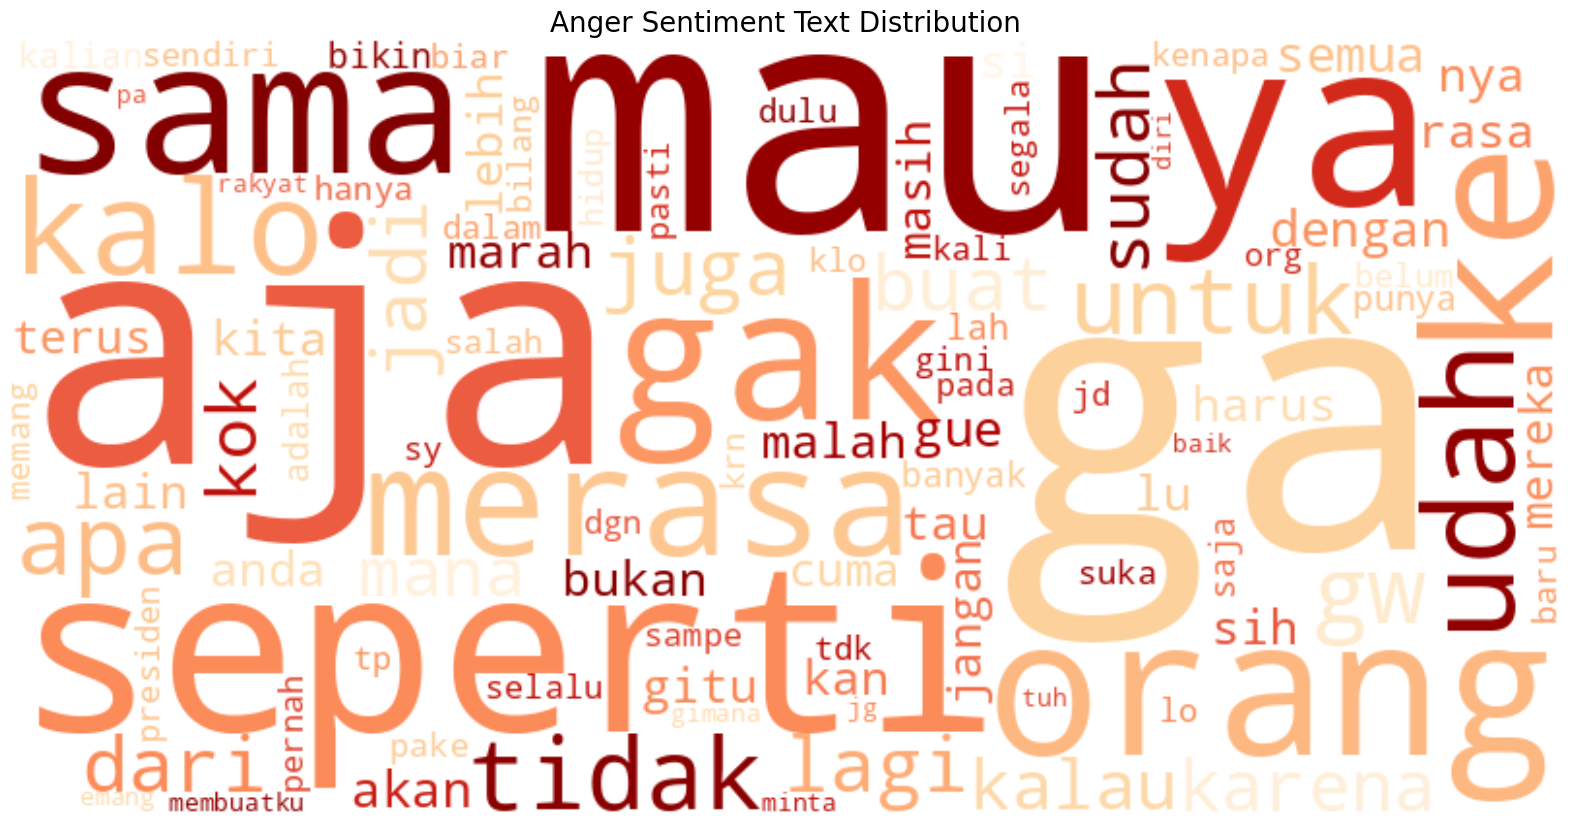

In [ ]:
anger_words = preprocess(train_test_df.loc[train_test_df['label'] == 'anger']['tweet'])
anger_words_df = create_freq_df(anger_words)
top10_anger_words = anger_words_df[:10]

plot_text_distribution(top10_anger_words['Term'], top10_anger_words['Frequency'],
                  'Reds', 'Top 10 Anger Sentiment Text Distribution', 'Text', 'Number of Texts')
create_wordcloud(anger_words_df, 'Anger Sentiment Text Distribution', 'OrRd')

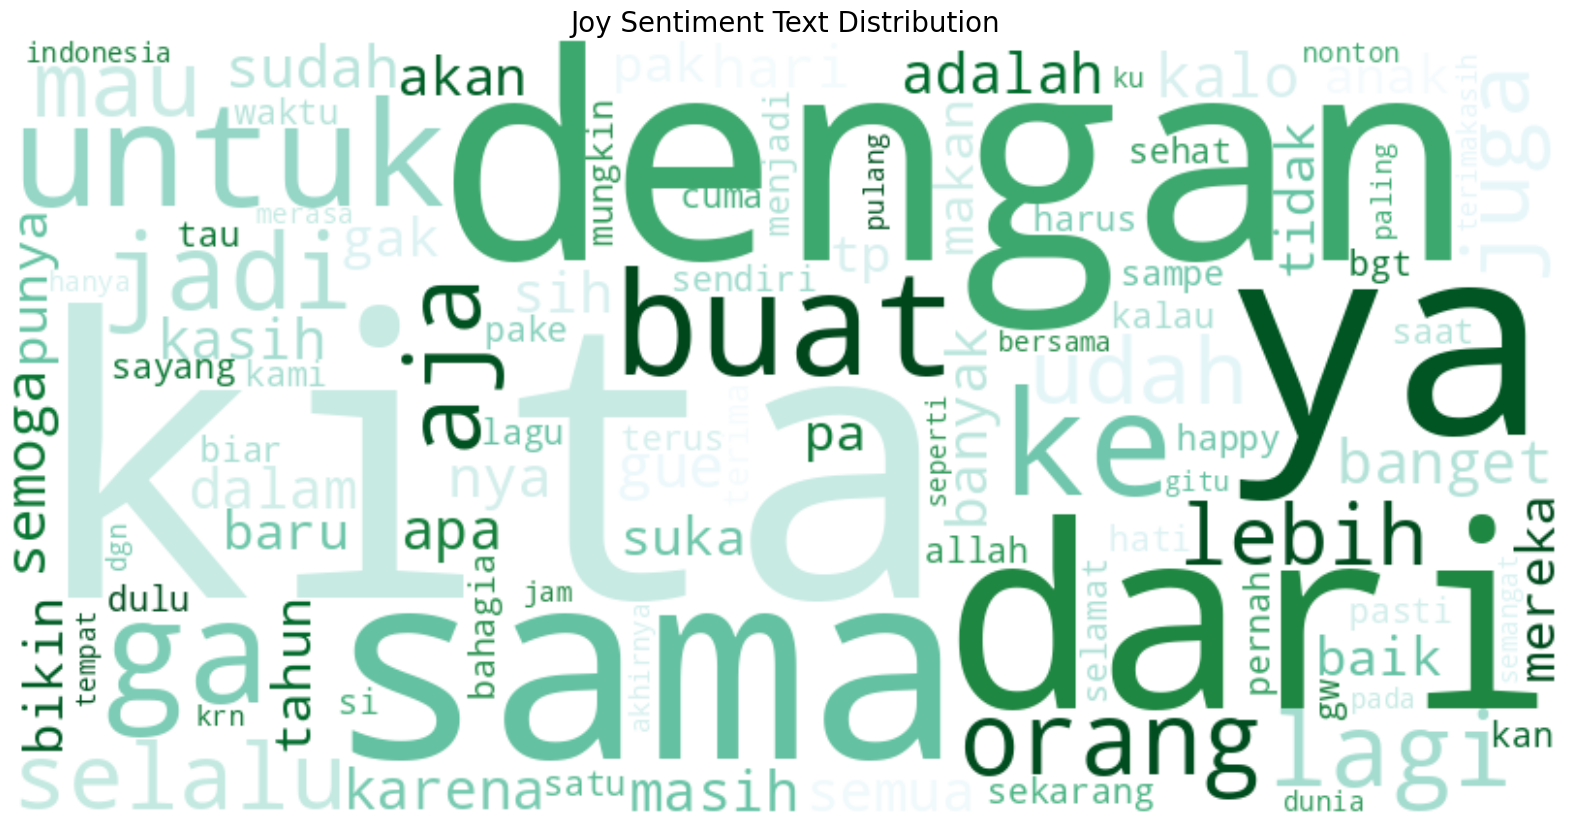

In [ ]:
joy_words = preprocess(train_test_df.loc[train_test_df['label'] == 'joy']['tweet'])
joy_words_df = create_freq_df(joy_words)
top10_joy_words = joy_words_df[:10]

plot_text_distribution(top10_joy_words['Term'], top10_joy_words['Frequency'],
                  'Greens', 'Top 10 Joy Sentiment Text Distribution', 'Text', 'Number of Texts')
create_wordcloud(joy_words_df, 'Joy Sentiment Text Distribution', 'BuGn')

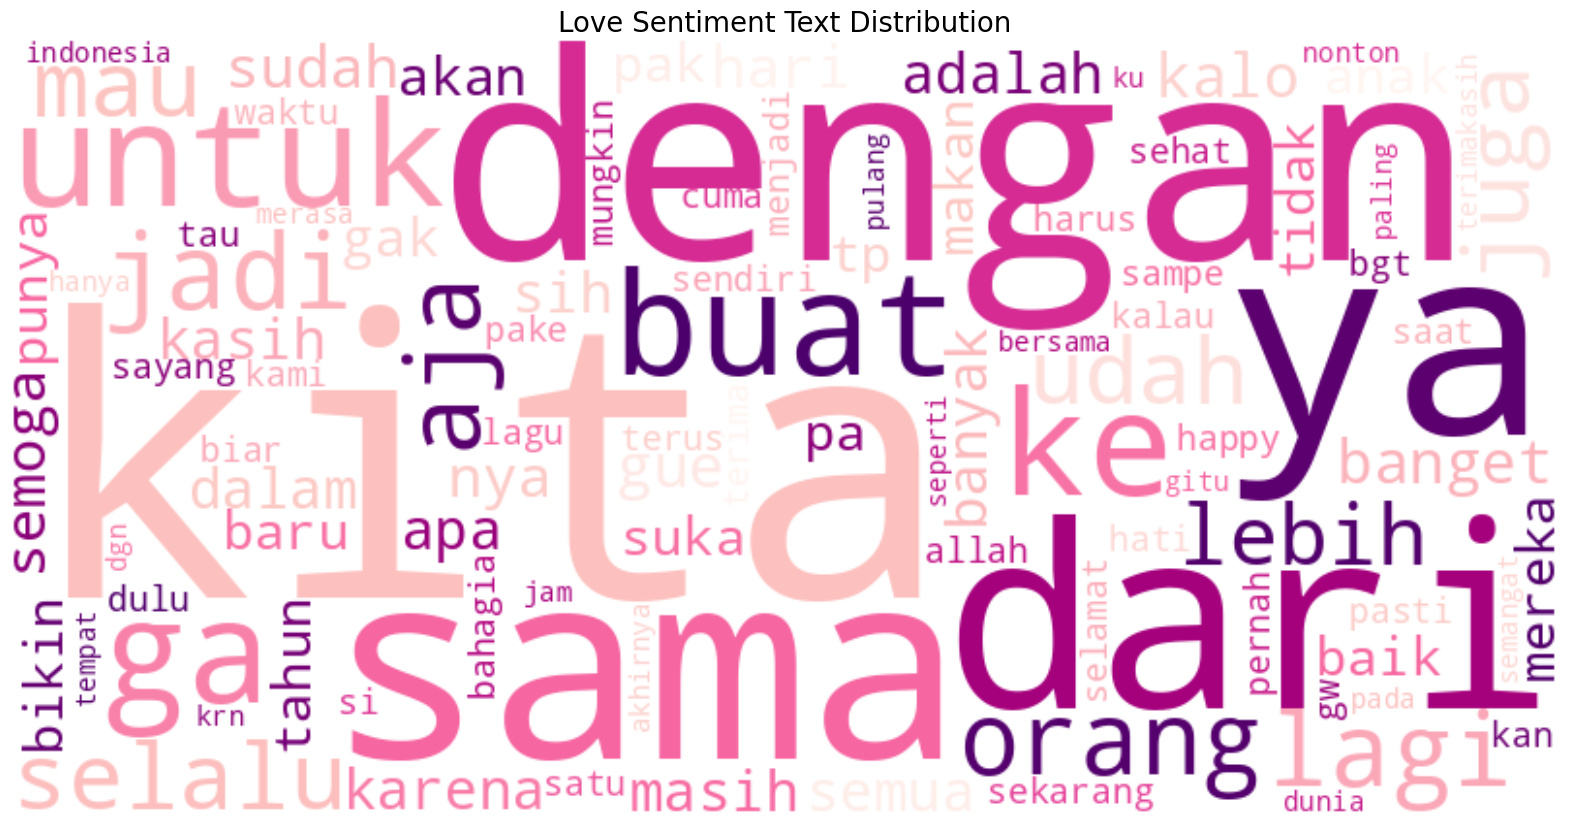

In [ ]:
love_words = preprocess(train_test_df.loc[train_test_df['label'] == 'joy']['tweet'])
love_words_df = create_freq_df(love_words)
top10_love_words = love_words_df[:10]

plot_text_distribution(top10_love_words['Term'], top10_love_words['Frequency'],
                  'Purples', 'Top 10 Love Sentiment Text Distribution', 'Text', 'Number of Texts')
create_wordcloud(love_words_df, 'Love Sentiment Text Distribution', 'RdPu')

### Polarity and Subjectivity

In [ ]:
import spacy
import re
from textblob import TextBlob

nlp = spacy.load('en_core_web_sm')

polarity = lambda x: TextBlob(x).sentiment.polarity
subjectivity = lambda x: TextBlob(x).sentiment.subjectivity

def polarity_and_subjectivity(x):
    a = re.findall(r'[\w\d]+', x)
    b = str()
    for i in a:
        b = b + str(' ') + str(i)
    c = polarity(b)
    d = subjectivity(b)
    return c, d

In [ ]:
pols = []
subs = []

for t in tweets:
    pol, sub = polarity_and_subjectivity(t)
    pols.append(pol)
    subs.append(sub)

train_test_df['polarity'] = pols
train_test_df['subjectivity'] = subs

<Figure size 500x2000 with 0 Axes>

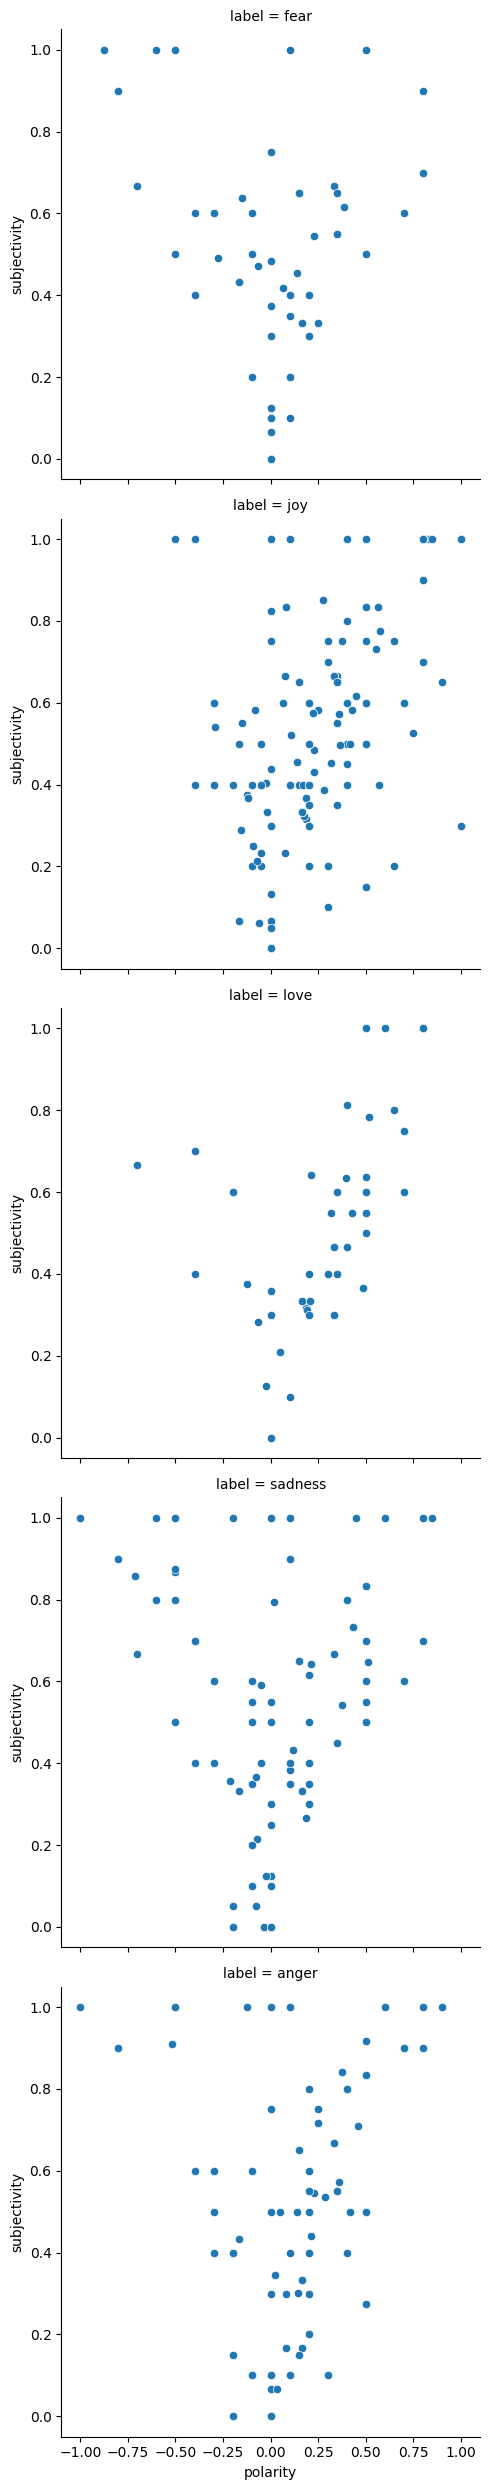

In [ ]:
plt.figure(figsize=(5, 20))
sns.relplot(data=train_test_df, x='polarity', y='subjectivity', row='label')

## Classification

### Count Vectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create a CountVectorizer to convert text data to numerical features
vectorizer = CountVectorizer(max_features=5000)  # You can adjust the max_features parameter

# Fit and transform the training data
X_train_vectorized = vectorizer.fit_transform(X_train).toarray()

# Transform the testing data using the same vectorizer
X_test_vectorized = vectorizer.transform(X_test).toarray()

# Initialize and train multiple classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Gaussian Naive-Bayes": GaussianNB(),
    "SVC": SVC(kernel='linear'),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(),
    "Ada Boost Classifier": AdaBoostClassifier()
}

results = {}

for name, clf in classifiers.items():
    clf.fit(X_train_vectorized, Y_train)
    Y_pred = clf.predict(X_test_vectorized)
    accuracy = accuracy_score(Y_test, Y_pred)
    report = classification_report(Y_test, Y_pred, target_names=["anger", "fear", "joy", "love", "sadness"])
    results[name] = {"Accuracy": accuracy, "Classification Report": report}

# Print results
for name, result in results.items():
    print(f"Classifier: {name}")
    print(f"Accuracy: {result['Accuracy']:.4f}")
    print("Classification Report:\n", result['Classification Report'])
    print("="*40)


Classifier: Logistic Regression
Accuracy: 0.6679
Classification Report:
               precision    recall  f1-score   support

       anger       0.65      0.64      0.65       171
        fear       0.79      0.66      0.72       140
         joy       0.68      0.71      0.70       206
        love       0.79      0.67      0.73       104
     sadness       0.56      0.65      0.60       210

    accuracy                           0.67       831
   macro avg       0.70      0.67      0.68       831
weighted avg       0.68      0.67      0.67       831

Classifier: Gaussian Naive-Bayes
Accuracy: 0.4813
Classification Report:
               precision    recall  f1-score   support

       anger       0.52      0.65      0.58       171
        fear       0.49      0.41      0.45       140
         joy       0.52      0.54      0.53       206
        love       0.36      0.37      0.36       104
     sadness       0.45      0.39      0.42       210

    accuracy                          

### Grid Search Count Vectorizer

In [ ]:
pipeline = Pipeline([
    ('tfidf_vect', TfidfVectorizer(stop_words='english')),
    ('lr_clf', LogisticRegression(solver='liblinear'))
])

params = {'tfidf_vect__ngram_range': [(1,1), (1,2), (1,3)],
          'tfidf_vect__max_df': [0.5, 0.75, 1.0],
          'lr_clf__C': [1, 5, 10]}

grid_cv_pipe = GridSearchCV(pipeline, param_grid=params, cv=3, scoring='accuracy', verbose=1)
grid_cv_pipe.fit(X_train, Y_train)
print('Optimized Hyperparameters: ', grid_cv_pipe.best_params_)

pred = grid_cv_pipe.predict(X_test)
print('Optimized Accuracy Score: {0: .3f}'.format(accuracy_score(Y_test, pred)))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Optimized Hyperparameters:  {'lr_clf__C': 10, 'tfidf_vect__max_df': 0.5, 'tfidf_vect__ngram_range': (1, 3)}
Optimized Accuracy Score:  0.711


## Prediction

In [ ]:
tweets_to_predict = predict_label['tweet']

tweets_to_predict

0      taKan raguKan besarNya kasih sayang Tuhan tela...
1      Cc in ke cebong2 dungu Maksd hati pengen cari ...
2      Nah keterlaluan adl kalo pjbt eselon menyalah2...
3      Melody masih membatasi diri ala member ya diba...
4      Rasa amarah membuatku merasa seperti akan melu...
                             ...                        
995    termasuk orang tidak habis pikir dengan orang ...
996     Melawan sibuk Selasamu jangan patah semangat yah
997    Momen mana merasa begitu mendalam terhubung de...
998    tentunya secara Bekasi halhal sayangnya tidak ...
999    Happy Mensive My Love makasih udh nemenin sela...
Name: tweet, Length: 1000, dtype: object

In [ ]:
  # Access the best estimator found by GridSearchCV
best_estimator = grid_cv_pipe.best_estimator_

# Transform the new tweets using the same TF-IDF vectorizer
X_predict = best_estimator.named_steps['tfidf_vect'].transform(tweets_to_predict)

# Make predictions for the new tweets
predicted_labels = best_estimator.named_steps['lr_clf'].predict(X_predict)  # Corrected

# Convert the predicted labels to a list
predicted_labels_list = predicted_labels.tolist()

# Assuming label_encoder is the LabelEncoder object used for encoding
decoded_labels = label_encoder.inverse_transform(predicted_labels_list)

# Create a DataFrame with the predicted labels
predicted_label_df = pd.DataFrame({'label': decoded_labels})

# Assuming you have a DataFrame 'predict_label' with the original tweets
# Add the predicted labels to the 'predict_label' DataFrame by creating a new DataFrame
predicted_tweet = pd.concat([predicted_label_df, predict_label['tweet']], axis=1)

predicted_tweet

,label,tweet
0,love,taKan raguKan besarNya kasih sayang Tuhan tela...
1,sadness,Cc in ke cebong2 dungu Maksd hati pengen cari ...
2,anger,Nah keterlaluan adl kalo pjbt eselon menyalah2...
3,sadness,Melody masih membatasi diri ala member ya diba...
4,anger,Rasa amarah membuatku merasa seperti akan melu...
...,...,...
995,anger,termasuk orang tidak habis pikir dengan orang ...
996,joy,Melawan sibuk Selasamu jangan patah semangat yah
997,love,Momen mana merasa begitu mendalam terhubung de...
998,anger,tentunya secara Bekasi halhal sayangnya tidak ...


In [ ]:
sentiment_counts = predicted_tweet['label'].value_counts().sort_index()

sentiment_labels = ['fear', 'joy', 'love', 'sadness', 'anger']
sentiment_colors = ['red', 'grey', 'green', 'blue', 'yellow']

fig = go.Figure(data=[go.Pie(labels=sentiment_counts.index,
                             values=sentiment_counts.values,
                             textinfo='percent+value+label',
                             marker_colors=sentiment_colors,
                             textposition='auto',
                             hole=.3)])

fig.update_layout(
    title_text='Sentiment Distribution',
    template='plotly_white',
    xaxis=dict(
        title='Sources',
    ),
    yaxis=dict(
        title='Number of Posts in Twitter',
    )
)

fig.update_traces(marker_line_color='black',
                  marker_line_width=1.5,
                  opacity=0.8)

fig.show()

In [ ]:
# Specify the file path where you want to save the CSV file
file_path = 'predicted_tweet.csv'

# Export the DataFrame to a CSV file
predicted_tweet.to_csv(file_path, index=False)